# Content and Objectives

- Show symbole error rate (SER) under different kinds of fading distributions
- channel is assumed to be slow flat, i.e.: $$Y= |H| \cdot X+Z_Y, \quad Z_Y\sim\mathcal{CN}(0,\sigma_Y^2)$$

- **NOTE:** We simulate attenuation only, no phase shift is considered 

# Import

In [1]:
# importing
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(18, 6) )

# Parameters

In [3]:
# constellation
constellation = np.array( [1+1j, 1-1j, -1-1j, -1+1j ])
constellation /= np.sqrt( np.average( np.abs( constellation )**2 ) )

# number of trials for estimating SER
N_points = int( 1e5 )

# Parameters for noise distributions
sigma2_Rayleigh = 1

sigma2_Rice = 1
A2_Rice = 10

M_Nakagami = 1
Omega_Nakagami = 5

# range of EsN0 values
Es_N0_dB = np.arange( 0, 31, 2 )
Es_N0 = 10** ( Es_N0_dB / 10 )
sigma2 = 1 / ( 2 * Es_N0 )

# max number of trials per SNR
N_trials = int( 1e4)
N_errors = 200

# Simulation

In [4]:
# do you want to normalize???
# choose according Boolean here
normalized = 0

In [5]:
# init random generator object
rng = np.random.default_rng()

ser_awgn = np.zeros_like( sigma2 )
ser_Rayleigh = np.zeros_like( sigma2 )
ser_Rice = np.zeros_like( sigma2 )
ser_Nakagami = np.zeros_like( sigma2 )

# loop for SNRs
for ind_noise, val_noise in enumerate( sigma2 ):

    # init error counter
    error_awgn = 0
    error_Rayleigh = 0
    error_Rice = 0
    error_Nakagami = 0

    # loop for realizations
    _n = 0
    while _n < N_trials and ( error_awgn < N_errors or error_Rice < N_errors ):

        # sample symbol to be transmitted
        X = np.random.choice( constellation )

         # get noise
        Z_Y = np.sqrt( val_noise / 2 ) * ( rng.normal( 0, 1 ) + 1j * rng.normal( 0, 1  ) )

        # get fading coefficients (you may opt in the interesting scenario)
        complex_Rayleigh_real = rng.normal( 0, 1 ) 
        complex_Rayleigh_imag = rng.normal( 0, 1 ) 
        H_Rayleigh = np.abs( np.sqrt( sigma2_Rayleigh / 2 ) * ( complex_Rayleigh_real + 1j * complex_Rayleigh_imag ) )

        complex_Rice_real = rng.normal( 0, 1 ) + np.sqrt( A2_Rice / 2 )
        complex_Rice_imag = rng.normal( 0, 1 ) + np.sqrt( A2_Rice / 2 )
        H_Rice = np.abs( np.sqrt( sigma2_Rice / 2 ) * ( complex_Rice_real + 1j * complex_Rice_imag ) )

        RV_Nakagami = stats.nakagami( nu=M_Nakagami, loc=0, scale=np.sqrt( Omega_Nakagami / M_Nakagami ) )
        H_Nakagami = RV_Nakagami.rvs( size=1 )

        # normalizing?
        if normalized:
            H_Rayleigh /= np.sqrt( np.average( np.abs( H_Rayleigh )**2 ) )
            H_Rice /= np.sqrt( np.average( np.abs( H_Rice )**2 ) )
            H_Nakagami /= np.sqrt( np.average( np.abs( H_Nakagami )**2 ) )

        # fade and noise
        Y_AWGN = X + Z_Y
        Y_Rayleigh = H_Rayleigh * X + Z_Y
        Y_Rice = H_Rice * X + Z_Y
        Y_Nakagami = H_Nakagami * X + Z_Y

        # demodulate
        X_est_AWGN = constellation[ ( np.abs( constellation - Y_AWGN )**2 ).argmin() ]
        X_est_Rayleigh = constellation[ ( np.abs( constellation - Y_Rayleigh )**2 ).argmin() ]
        X_est_Rice = constellation[ ( np.abs( constellation - Y_Rice )**2 ).argmin() ]
        X_est_Nakagami = constellation[ ( np.abs( constellation - Y_Nakagami )**2 ).argmin() ]


        # check and increase error counter
        error_awgn += 1 - int( np.isclose( X_est_AWGN, X) )
        error_Rayleigh += 1 - int( np.isclose( X_est_Rayleigh, X) )
        error_Rice += 1 - int( np.isclose( X_est_Rice, X) )
        error_Nakagami += 1 - int( np.isclose( X_est_Nakagami, X) )


        # increase loop counter
        _n += 1

    # put in error rates
    ser_awgn[ ind_noise ] = error_awgn / _n
    ser_Rayleigh[ ind_noise ] = error_Rayleigh / _n
    ser_Rice[ ind_noise ] = error_Rice / _n
    ser_Nakagami[ ind_noise ] = error_Nakagami / _n

    # give some feedback on where we are
    print('Done: {} dB'.format( Es_N0_dB[ ind_noise ] ) )

        

Done: 0 dB
Done: 2 dB
Done: 4 dB
Done: 6 dB
Done: 8 dB
Done: 10 dB
Done: 12 dB
Done: 14 dB
Done: 16 dB
Done: 18 dB
Done: 20 dB
Done: 22 dB
Done: 24 dB
Done: 26 dB
Done: 28 dB
Done: 30 dB


### Plotting the SERs

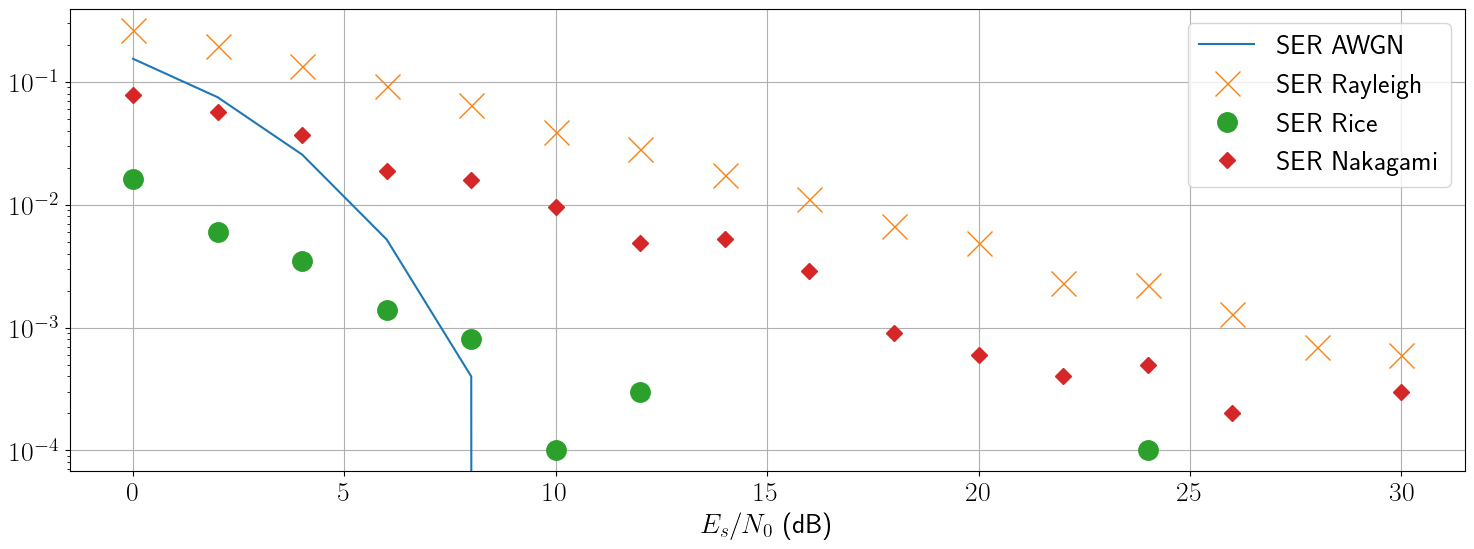

In [6]:
plt.semilogy( Es_N0_dB, ser_awgn, label='SER AWGN')
plt.semilogy( Es_N0_dB, ser_Rayleigh, 'x', ms=18, label='SER Rayleigh')
plt.semilogy( Es_N0_dB, ser_Rice, 'o', ms=14, label='SER Rice')
plt.semilogy( Es_N0_dB, ser_Nakagami, 'D', ms=8, label='SER Nakagami')
plt.xlabel(' $E_s/N_0$ (dB)')
plt.grid( True )
plt.legend()
plt.show()
